In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import scipy.interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.cm as cm

In [2]:
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('text', usetex=True)
font_size = 18
rc('font', size=font_size)
rc('axes', labelsize=font_size)
rc('axes', titlesize=font_size)

In [3]:
reg_param = 0.03125
xs = np.load('hill_flat_inversion_' + str(reg_param) + '.npy')
fault = np.load('hill_flat_fault.npy')

In [4]:
def topo(x, y, flat):
    z = np.zeros_like(x)
    if flat:
        return z

    C = [0, 0]
    hill_height = 2 * 1000
    hill_xradius = 7 * 1000
    hill_yradius = 7 * 1000

    z += hill_height * np.exp(
        -(((x - C[0]) / hill_xradius) ** 2 + ((y - C[1]) / hill_yradius) ** 2)
    )

    return z

In [5]:
x = np.linspace(-45000, 45000)
y = 0 * x
z = topo(x, y, flat = False)

In [6]:
def get_vert_vals(m, x):
    vert_tris = [[] for i in range(m[0].shape[0])]
    for i in range(m[1].shape[0]):
        for d in range(3):
            vert_tris[m[1][i,d]].append(i)
    vert_n_tris = [len(ts) for ts in vert_tris]
    vert_vals = np.zeros(m[0].shape[0])
    for i in range(m[1].shape[0]):
        for d in range(3):
            vert_vals[m[1][i,d]] += x[i]
    vert_vals /= vert_n_tris
    return vert_vals

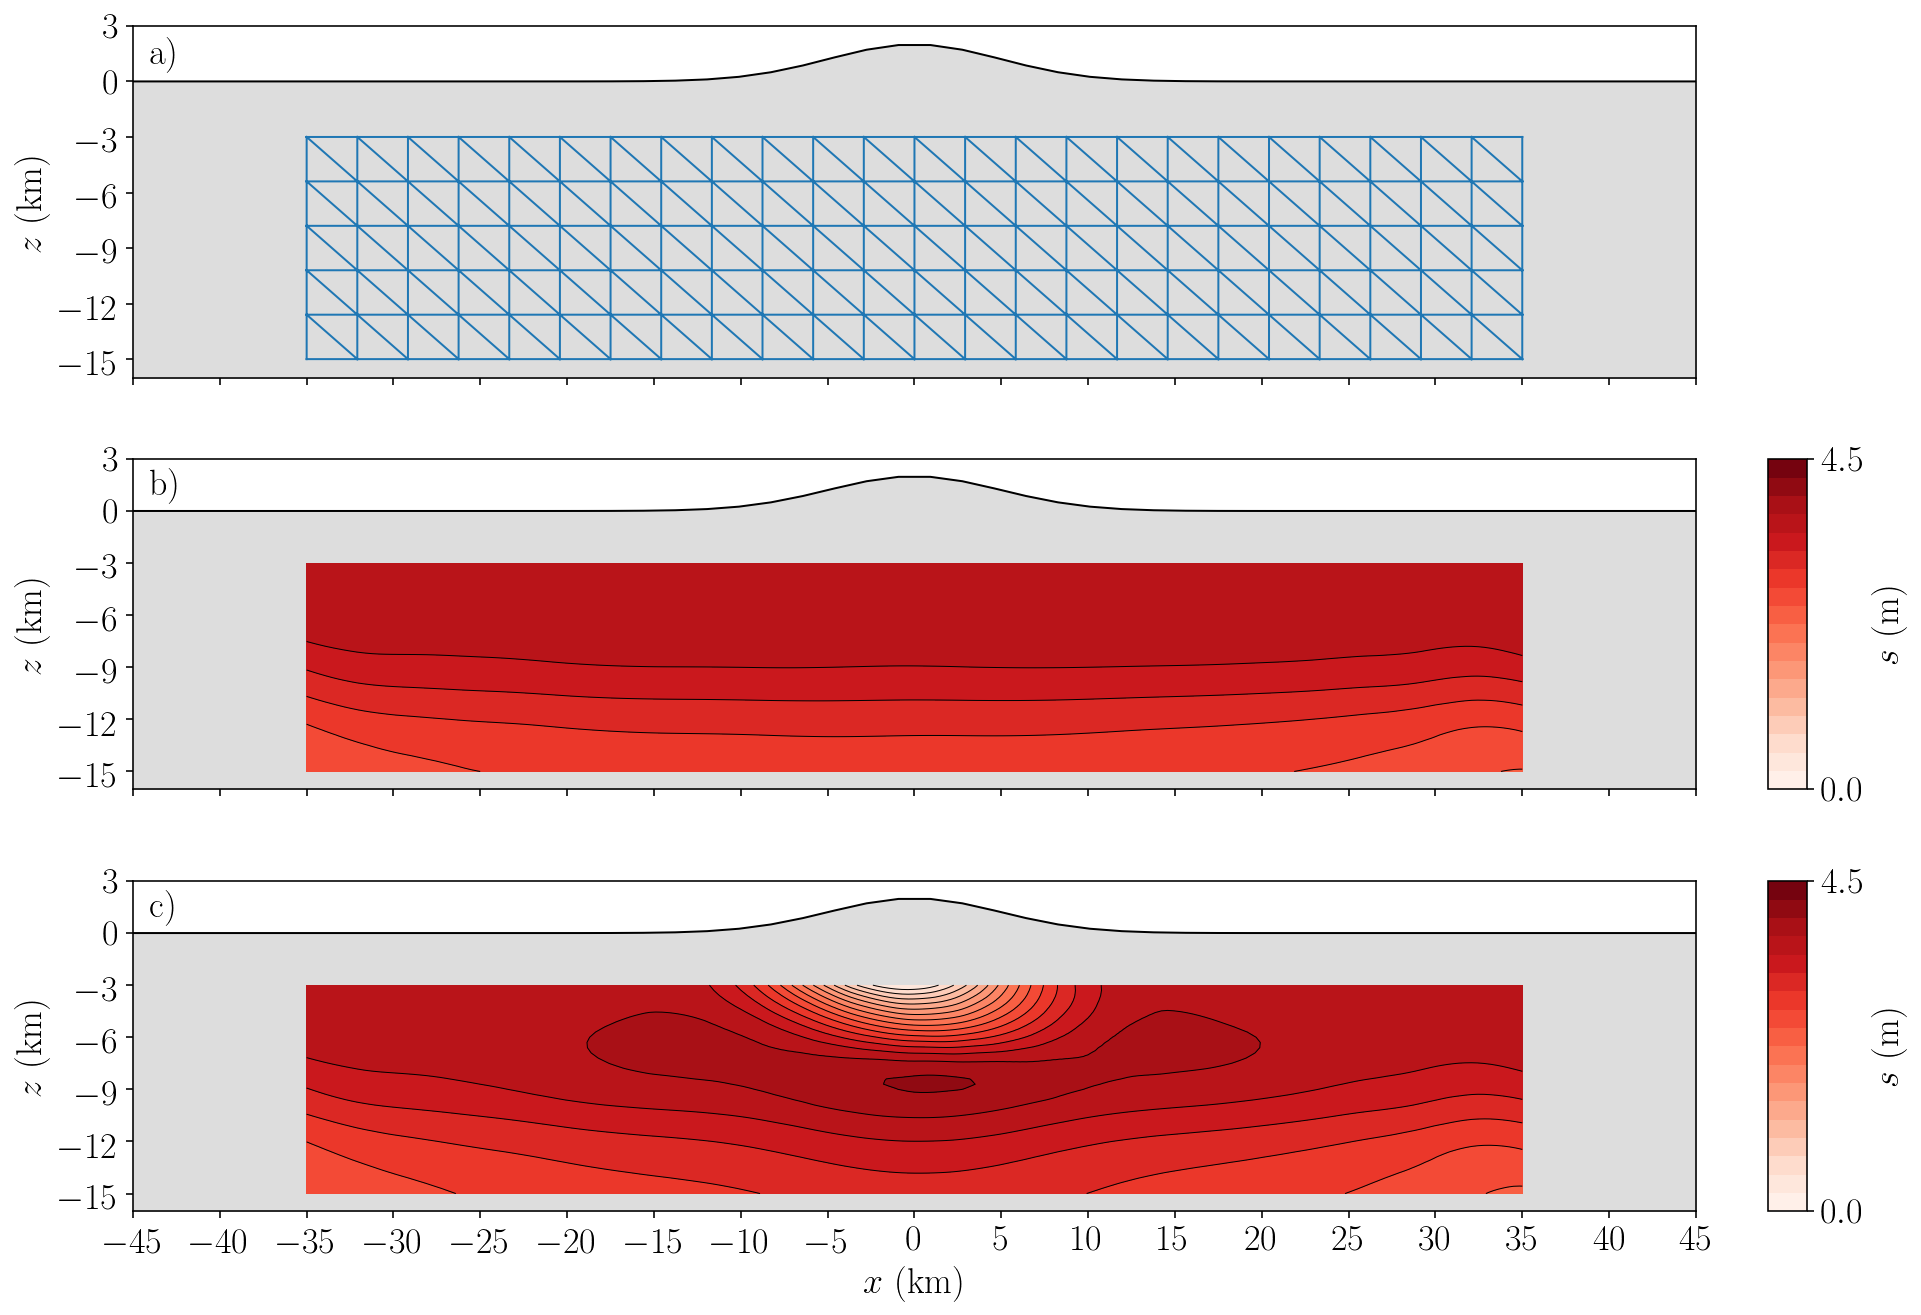

In [15]:
fig = plt.figure(figsize = (15, 11))
ax1 = plt.subplot(311)
# ax1.set_aspect('equal')

bg_color = '#DDDDDD'
ax1.plot(x / 1000, z / 1000, 'k-', linewidth = 1)
ax1.fill_between(x / 1000.0, np.ones_like(x) * -20, z / 1000.0, color = bg_color)
triang = tri.Triangulation(fault[0][:,0] / 1000.0, fault[0][:,2] / 1000.0, fault[1])
ax1.triplot(triang, linewidth = 1)
ax1.text(-44, 1, '$\mathrm{a)}$')

xticks = np.linspace(-45.0, 45.0, 19)
yticks = np.linspace(3.0, -15.0, 7)
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xlim([-45, 45])
ax1.set_ylim([-16, 3])
#ax1.set_xlabel('$x ~\\mathrm{(km)}$')
ax1.set_ylabel('$z ~\\mathrm{(km)}$')
#ax1.set_aspect('equal')
# ax1.spines["top"].set_visible(False)
# ax1.spines["bottom"].set_visible(False)
# ax1.spines["right"].set_visible(False)
# ax1.spines["left"].set_visible(False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2.5%", pad=0.5)
cax.axis('off')
plt.setp(ax1.get_xticklabels(), visible=False)

axs = [plt.subplot(312)]
axs.append(plt.subplot(313, sharex = axs[0]))
for i, field in enumerate([-xs[1][1::2], -xs[0][1::2]]):
    axi = axs[i]
    
    axi.plot(x / 1000, z / 1000, 'k-', linewidth = 1)
    axi.fill_between(x / 1000.0, np.ones_like(x) * -20, z / 1000.0, color = bg_color)
    vert_vals = get_vert_vals(fault, field)
    triang = tri.Triangulation(fault[0][:,0] / 1000.0, fault[0][:,2] / 1000.0, fault[1])
    refiner = tri.UniformTriRefiner(triang)
    tri_refi, z_test_refi = refiner.refine_field(vert_vals, subdiv=3)

    axi.set_aspect('equal')
    # plt.triplot(triang, lw = 0.5, color = 'white')

    levels = np.linspace(0, 4.5, 19)
    # cmap = cm.get_cmap(name='terrain', lut=None)
    cmap = cm.get_cmap(name='Reds')
    cntf = axi.tricontourf(tri_refi, z_test_refi, levels=levels, cmap=cmap)
    axi.tricontour(
        tri_refi, z_test_refi, levels=levels,
        linestyles = 'solid',
        colors=['k'],
        linewidths=[0.5]
    )
    
    axi.text(-44, 1, ['$\mathrm{b)}$', '$\mathrm{c)}$'][i])

    axi.set_xticks(xticks)
    axi.set_yticks(yticks)
    axi.set_xlim([-45, 45])
    axi.set_ylim([-16, 3])
    
    axi.set_ylabel('$z ~\\mathrm{(km)}$')

    divider = make_axes_locatable(axi)
    cax = divider.append_axes("right", size="2.5%", pad=0.5)
    cbar = plt.colorbar(cntf, cax = cax)
    cbar.set_label('$s ~\\mathrm{(m)}$')
    cbar_levels = [levels[0], levels[-1]]
    cbar.set_ticks(cbar_levels)
    cbar.set_ticklabels(['$' + str(l) + '$' for l in cbar_levels])
    if i == 0:
        plt.setp(axi.get_xticklabels(), visible=False)
    else:
        axi.set_xlabel('$x ~\\mathrm{(km)}$')
plt.savefig('brendan_talk_shallow_slip.pdf')
plt.show()